<a href="https://colab.research.google.com/github/Sgsouham/kaggle_datasets_work/blob/master/basicLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title
from google.colab import files
files.upload()

In [0]:
#@title

!cp kaggle.json ~/.kaggle/kaggle.json

In [0]:
#@title

! chmod 600 ~/.kaggle/kaggle.json

In [0]:
#@title
! kaggle datasets list

In [0]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset -p/content

 54% 22.0M/41.0M [00:00<00:00, 95.5MB/s]
100% 41.0M/41.0M [00:00<00:00, 137MB/s] 


In [0]:
!unzip \*.zip

Archive:  fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


# So this is not going to be a beginner level notebook but is going to generalize the entire NLP pipeline.

###1) As Usual data loading.

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

In [0]:


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split

import string

from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

import plotly
plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objects as go


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import pandas as pd
pd_fake= pd.read_csv('Fake.csv')
pd_true= pd.read_csv('True.csv')

In [0]:
pd_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [0]:
pd_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


####To be honest seeing the dataset in two halves and alos seeing the subject, I thought the subjects are going to be the Fake and true labels.   :-P So I wanted to check how many different classes are there in total in each. 

In [0]:
pd_fake['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

In [0]:
pd_true['subject'].value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

#### We simply label encode the dataframes and concat them together. Now to get rid of the pattern, We shuffle them also. Quite intuitive I suppose.

In [0]:
pd_true['category']=1
pd_fake['category']=0
df=pd.concat([pd_true,pd_fake])

In [0]:
from sklearn.utils import shuffle
df = shuffle(df).reset_index(drop=True)

In [0]:
df.head()

,title,text,subject,date,category
0,We're all human: 'Nudge' theorist Thaler wins ...,STOCKHOLM/CHICAGO (Reuters) - U.S. academic R...,worldnews,"October 9, 2017",1
1,BREAKING: 4 AMERICAN HOSTAGES TAKEN BY IRAN-BA...,These 4 hostages must certainly feel a sense o...,politics,"May 30, 2015",0
2,"NANCY PELOSI, DEMOCRATS and ANTIFA Force Conse...",Joey Gibson of the group Patriot Prayer had pl...,politics,"Aug 27, 2017",0
3,Virginia governor signs gun law compromise mea...,(Reuters) - Virginia Governor Terry McAuliffe ...,politicsNews,"February 26, 2016",1
4,The New American Mediocrity: Ash Carter vs Dr....,21st Century Wire says US Defense Secretary As...,Middle-east,"June 2, 2016",0


###2) Basic Data visualization.

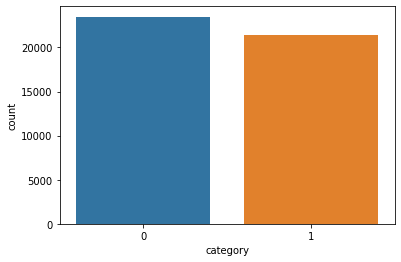

In [0]:
import seaborn as sns
sns.countplot(df['category'], data=df)

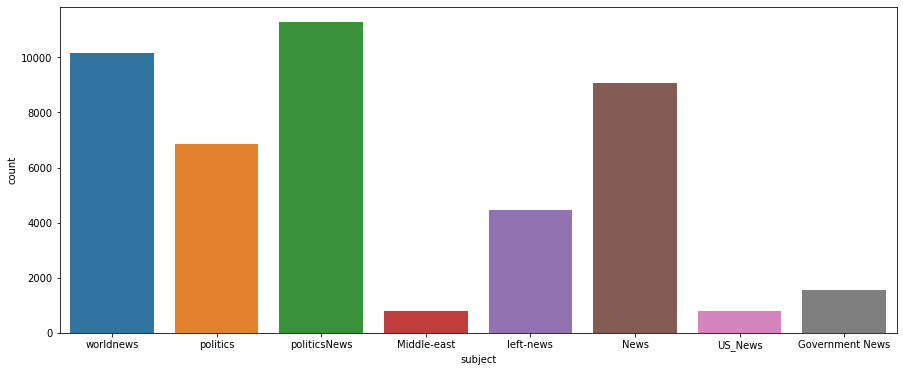

In [0]:
import matplotlib.pyplot as plt

fig_dims = (15, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(df['subject'], data=df, ax=ax)

In [0]:
from wordcloud import WordCloud,STOPWORDS

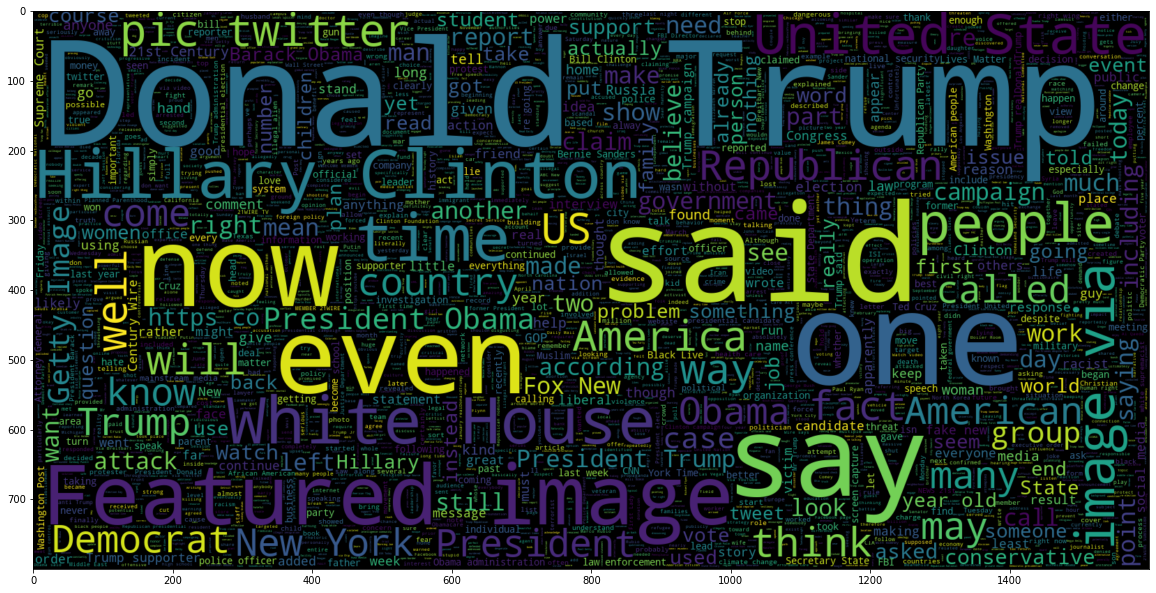

In [0]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.category == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

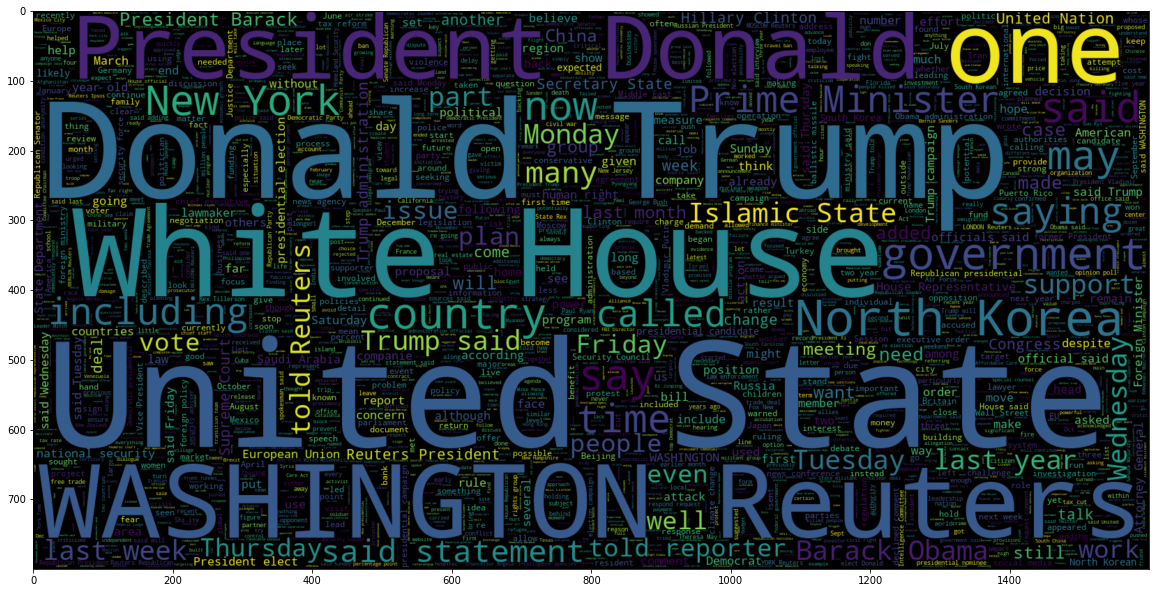

In [0]:
plt.figure(figsize = (20,20)) # Text that is fraudulent(1)
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df[df.category == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

#### Now there are many approaches that we can take to convert the text into a form that is "feedable" to our model. BoW or bag of words is one such model that takes away the literal insights of the text and marks the frequency of each word.This would be a good apporach if we plan to use the normal ML algorithms which dal with the statistical relationships among the features but when using neural nets this wont be a proper method, the reason being, when we use RNN (LSTM) models we want our model to understand the specific meaning of the "sequences" that come in as well. This technique is mainly used for training chatbots or models in which the output has to be "meaningful". We will be using the technique here anyway just to see if works as an overkill.

In [0]:
# Hyperparameters for title and text
vocab_size = 100000
embedding_dim_title = 128
max_length_title = 40
embedding_dim_text = 500
max_length_text = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
test_ratio = .3
embedding_dim = 500
max_length_text = 500

In [0]:
# Text cleaning
def clean(text):
    #1. Remove punctuation
    translator1 = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    text = text.translate(translator1)
    
    #2. Convert to lowercase characters
    text = text.lower()
    
    #3. Remove stopwords
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    
    return text
# Apply cleaning to title and text in dataset
df['title'] = df['title'].apply(clean)
df['text'] = df['text'].apply(clean)
df.sample(10)

,title,text,subject,date,category
36258,2 senate republican health bill discussed tues...,washington reuters senator john cornyn 2 senat...,politicsNews,"July 24, 2017",1
37021,u commerce department launch china market econ...,washington reuters u commerce department launc...,politicsNews,"March 30, 2017",1
28806,two trump campaign officials met russian envoy...,washington reuters least two additional offici...,politicsNews,"March 2, 2017",1
3732,mcconnell suppressed info russia worked elect ...,news cia solid evidence russia indeed meddle e...,News,"December 10, 2016",0
12143,video trump cnn’s anderson cooper “the people ...,love hate trump speaking saying things conserv...,politics,"Jul 23, 2015",0
10540,merkel ally cites thousands cyber attacks russ...,berlin reuters top leader german chancellor an...,worldnews,"September 4, 2017",1
41751,house panel consider tweaks healthcare bill re...,washington reuters u house representatives pan...,politicsNews,"April 6, 2017",1
1205,bill bennett rips never trumpers…the voice rea...,bill bennett voice reason conservatives incred...,politics,"Aug 20, 2016",0
25546,aggressive cuts obama era green rules start so...,reuters u president donald trump’s administrat...,politicsNews,"February 25, 2017",1
39887,hillary loves idea barack obama supreme court ...,remember would seem like far fetched idea demo...,left-news,"Jul 31, 2016",0


####Pad Sequences ensures that every token is of same length.
pad_sequences is used to ensure that all sequences in a list have the same length. By default this is done by padding 0 in the beginning of each sequence until each sequence has the same length as the longest sequence.



In [0]:
def preprocessing(data, dependent_column=None, target='category', max_len=40):
    train_X, test_X, train_y, test_y = train_test_split(df[dependent_column], df[target], test_size=test_ratio)
    tokenizer = Tokenizer(num_words=vocab_size,
                          oov_token=oov_tok)
    tokenizer.fit_on_texts(train_X)
    train_sequences = tokenizer.texts_to_sequences(train_X)
    train_padded = pad_sequences(train_sequences, maxlen=max_len,
                                padding=padding_type,
                                truncating=trunc_type)
    test_sequences = tokenizer.texts_to_sequences(test_X)
    test_padded = pad_sequences(test_sequences, maxlen=max_len,
                               padding=padding_type,
                               truncating=trunc_type)
    return train_padded, test_padded, train_y, test_y

Model Creation 
###Actual LSTM###

In [0]:
def model_creation(vocab_size=vocab_size, embedding_dim=128):
        model = tf.keras.Sequential()
        model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
        model.add(tf.keras.layers.Dense(embedding_dim, activation='relu'))
        model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])
        return model

A Function to use the testX and testY as validation.

In [0]:
def train_model(model, train_X, train_Y, test_X, test_Y, epochs):
    class CustomCallback(Callback):
        def on_epoch_end(self, epoch, logs={}):
            if logs.get('acc') > 0.99:
                print(f'Accuracy reached {logs.get("acc")*100:0.2f}. Stopping the training')
                self.model.stop_training = True

    history = model.fit(train_X, train_Y,
                       epochs=epochs,
                       batch_size=64,
                       validation_data=[test_X, test_Y],
                       callbacks=[CustomCallback()])
    return history

Using the Title as a feature.

In [0]:
train_padded, test_padded, train_y, test_y = preprocessing(df, dependent_column='title', max_len=max_length_title)
model = model_creation(embedding_dim=embedding_dim_title)
history_title = train_model(model, train_padded, train_y, test_padded, test_y, 15)

Epoch 1/15
492/492 [==============================] - 171s 347ms/step - loss: 0.1552 - acc: 0.9348 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/15
492/492 [==============================] - 173s 351ms/step - loss: 0.0378 - acc: 0.9873 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/15
492/492 [==============================] - 168s 341ms/step - loss: 0.0137 - acc: 0.9950 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


Using the Text as a feature.

In [0]:
train_padded, test_padded, train_y, test_y = preprocessing(df, dependent_column='text', max_len=max_length_title)
model = model_creation(embedding_dim=embedding_dim_text)
history_text = train_model(model, train_padded, train_y, test_padded, test_y, 15)

Epoch 1/15
492/492 [==============================] - 1278s 3s/step - loss: 0.0240 - acc: 0.9917 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
